<a href="https://colab.research.google.com/github/justaguyalways/Mine-The-Model-hackathon-Celesta/blob/main/Mine_the_model_Luxury_predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/Mine_the_Model/test_images.zip

Archive:  /content/drive/MyDrive/Mine_the_Model/test_images.zip
replace test/9871.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/drive/MyDrive/Mine_the_Model/train_images.zip

Archive:  /content/drive/MyDrive/Mine_the_Model/train_images.zip
replace train/9934.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import glob

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preparation
from sklearn.preprocessing import RobustScaler, StandardScaler
from datetime import datetime
import math

# Modeling
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, r2_score, precision_score, recall_score, classification_report, confusion_matrix
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Mine_the_Model/test.csv", index_col="index")
df_train = pd.read_csv("/content/drive/MyDrive/Mine_the_Model/train.csv", index_col="index")
df_train.head()

,rooms,retail_price,address,city,sqft,toilets,image_id
index,,,,,,,
5832,2.0,299000,81913 Calle Torbellino,"Indio, CA",1295.0,2.0,5832
5584,3.0,299000,26076 Fiesta Place,"Hemet, CA",1566.0,2.0,5584
9408,5.0,499990,34450 Fawn Ridge Place,"Yucaipa, CA",3068.0,3.0,9408
4644,4.0,849900,26481 Montebello Place,"Mission Viejo, CA",2230.0,2.1,4644
5739,3.0,333490,2562 Red Spruce Lane,"San Jacinto, CA",1898.0,2.0,5739


In [ ]:
df_train.describe()

,rooms,retail_price,sqft,toilets,image_id
count,8204.000000,8.400000e+03,8253.000000,8400.000000,8400.000000
mean,3.484154,6.746794e+05,2162.801648,2.451714,6011.068690
std,1.028957,3.901718e+05,1050.270982,0.941510,3473.684303
min,1.000000,1.950000e+05,280.000000,0.000000,0.000000
25%,3.000000,3.990000e+05,1386.000000,2.000000,2998.750000
50%,3.000000,5.854500e+05,1919.000000,2.100000,6066.500000
75%,4.000000,7.990000e+05,2761.000000,3.000000,9031.250000
max,10.000000,2.000000e+06,11183.000000,8.100000,11999.000000


index
rooms
retail_price
address
city
sqft
toilets
image_id


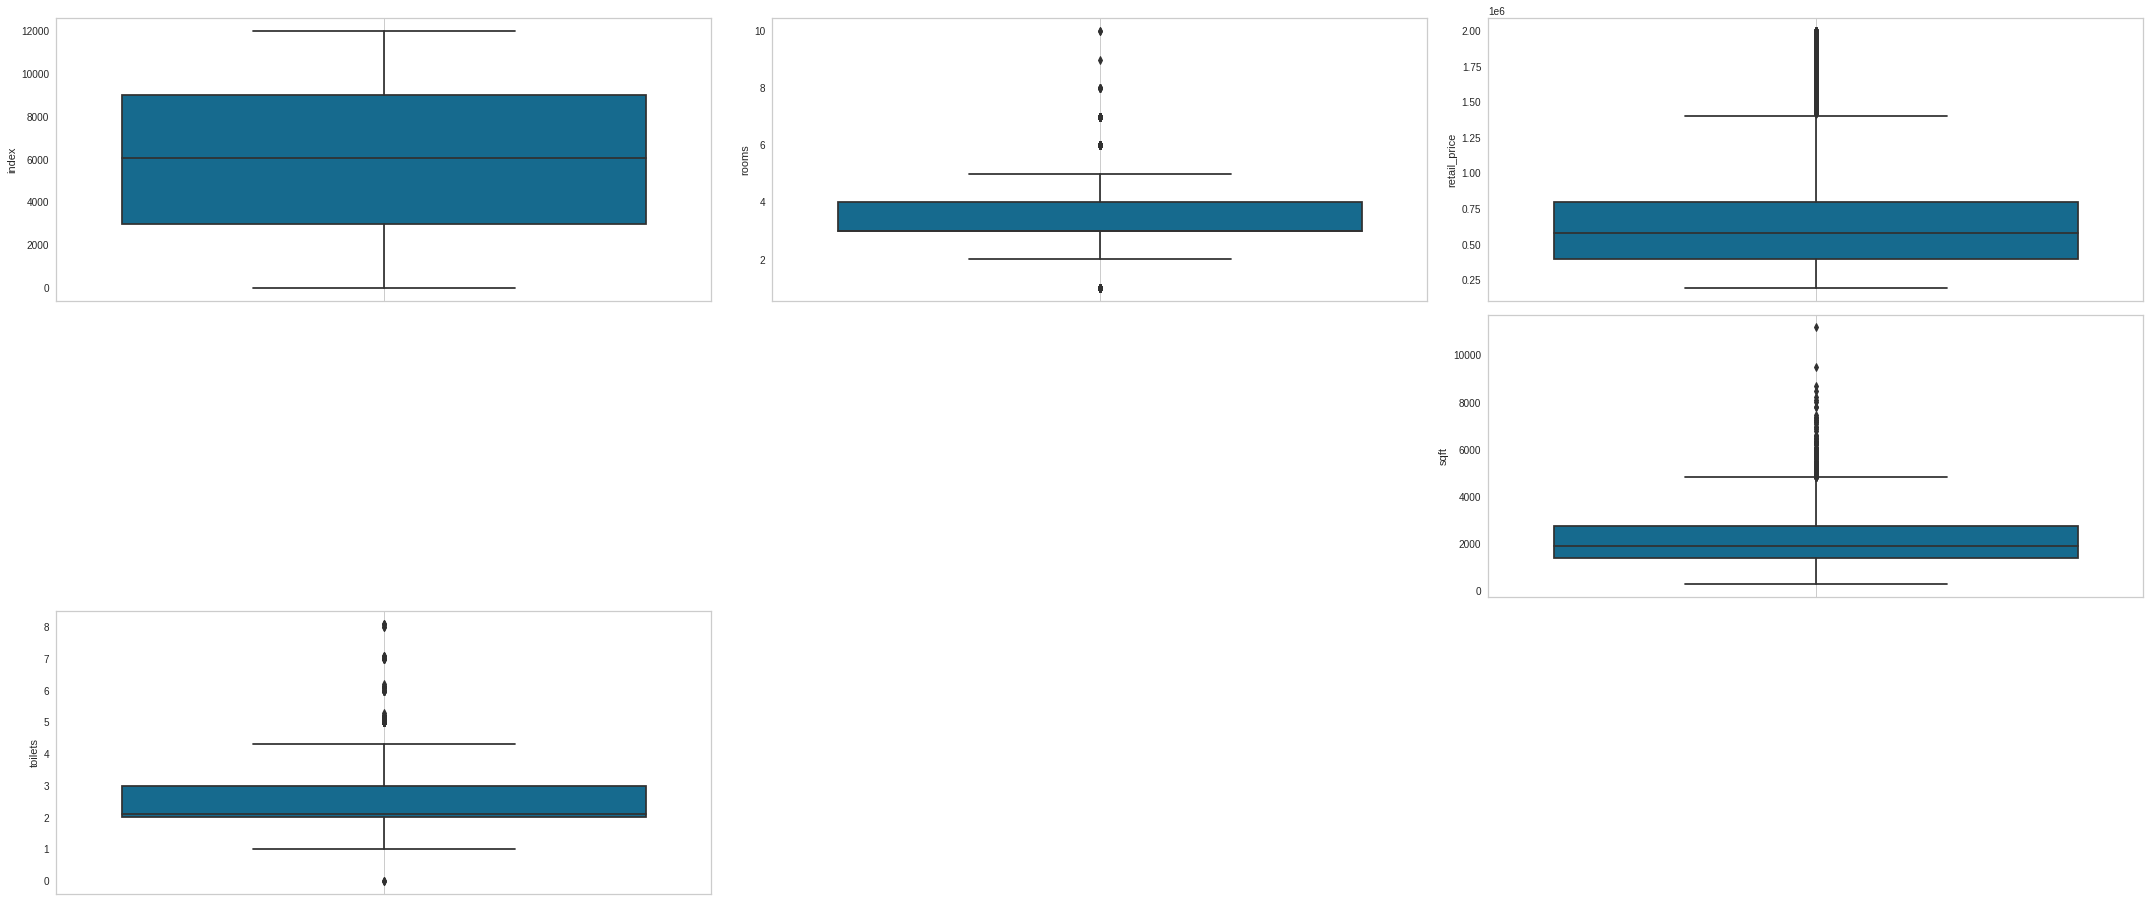

In [ ]:
# Check outliers 
fig = plt.figure(figsize=(30,25))
for index,col in enumerate(df_train):
  print(col)
  if(col in ["address", "city", "image_id"]):
    continue
  plt.subplot(6,3,index+1)
  sns.boxplot(y=col, data=df_train.dropna())
  plt.grid()
fig.tight_layout(pad=1.0)

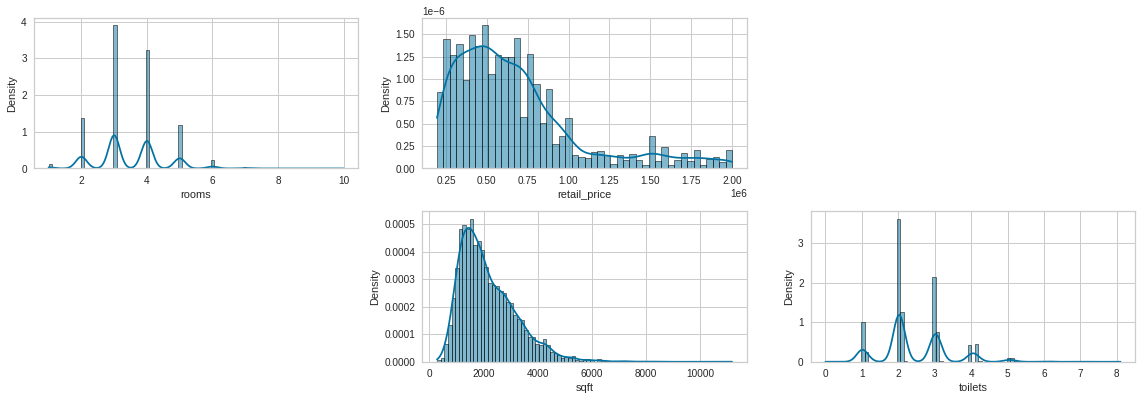

In [ ]:
fig = plt.figure(figsize=(16,16))
for index,col in enumerate(df_train):
    if(col in ["address", "city", "image_id"]):
      continue
    plt.subplot(6,3,index+1)
    sns.histplot(df_train.loc[:,col].dropna(), kde=True, stat="density", linewidth=0.5);
    
fig.tight_layout(pad=1.0);


In [ ]:
df_train1 = df_train[df_train['rooms'] < 6]
print(len(df_train1))
df_train1 = df_train1[df_train1['rooms'] >1] 
print(len(df_train1))
df_train1.head()

df_train1 = df_train1[df_train1['toilets'] >0] 
print(len(df_train1))
df_train1 = df_train1[df_train1['toilets'] < 5]
print(len(df_train1))
df_train1.head() 
df_train1 = df_train1[df_train1['retail_price'] < 1.675 * 1e6] 
print(len(df_train1))
df_train1 = df_train1[df_train1['sqft'] < 5500] 
print(len(df_train1))
df_train1.head()


7975
7866
7863
7724
7476
7328


,rooms,retail_price,address,city,sqft,toilets,image_id
index,,,,,,,
5832,2.0,299000,81913 Calle Torbellino,"Indio, CA",1295.0,2.0,5832
5584,3.0,299000,26076 Fiesta Place,"Hemet, CA",1566.0,2.0,5584
9408,5.0,499990,34450 Fawn Ridge Place,"Yucaipa, CA",3068.0,3.0,9408
4644,4.0,849900,26481 Montebello Place,"Mission Viejo, CA",2230.0,2.1,4644
5739,3.0,333490,2562 Red Spruce Lane,"San Jacinto, CA",1898.0,2.0,5739


In [ ]:
len(df_train1)

7328

In [ ]:
len(df_train)

8400

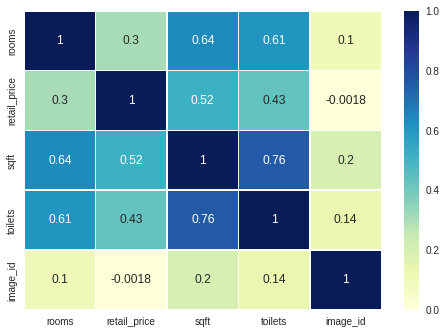

In [ ]:
correl = df_train1.corr()
sns.heatmap(correl, cmap = 'YlGnBu', annot= True, linewidths=.5);

In [ ]:
df_train.describe()

,rooms,retail_price,sqft,toilets,image_id
count,8204.000000,8.400000e+03,8253.000000,8400.000000,8400.000000
mean,3.484154,6.746794e+05,2162.801648,2.451714,6011.068690
std,1.028957,3.901718e+05,1050.270982,0.941510,3473.684303
min,1.000000,1.950000e+05,280.000000,0.000000,0.000000
25%,3.000000,3.990000e+05,1386.000000,2.000000,2998.750000
50%,3.000000,5.854500e+05,1919.000000,2.100000,6066.500000
75%,4.000000,7.990000e+05,2761.000000,3.000000,9031.250000
max,10.000000,2.000000e+06,11183.000000,8.100000,11999.000000


In [ ]:
df_train.quantile(q = 0.334)

rooms                3.00
retail_price    449900.00
sqft              1528.18
toilets              2.00
image_id          4088.36
Name: 0.34, dtype: float64

In [ ]:
df_train.quantile(q = 0.667)

index             8036.133
rooms                4.000
retail_price    725000.000
sqft              2437.084
toilets              3.000
image_id          8036.133
Name: 0.667, dtype: float64

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Mine_the_Model/train.csv", index_col="index")
df_train.reset_index(inplace = True)
image_list0 = []
image_list1 = []
image_list2 = []
image_list3 = []
prices = df_train.get('retail_price')
image_id = df_train.get('image_id')
k = 0
for i , j in enumerate(prices):
  k = i
  if(j < 399000):
    image_list0.append(image_id[i])
  elif(j < 585450):
    image_list1.append(image_id[i])
  elif(j < 799000):
    image_list2.append(image_id[i])
  else:
    image_list3.append(image_id[i])

In [ ]:
print(len(image_list0),len(image_list1),len(image_list2),len(image_list3))

2038 2162 2011 2189


Making pytorch custom dataset

In [ ]:
import os
import pandas as pd
import torch
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
x = list(zip(image_list0,(i-i for i in range(len(image_list0)))))
y = list(zip(image_list1,(i-i+1 for i in range(len(image_list1)))))
z = list(zip(image_list2,(i-i+2 for i in range(len(image_list2)))))
a = list(zip(image_list3,(i-i+3 for i in range(len(image_list3)))))


In [ ]:
x.extend(y)
x.extend(z)
x.extend(a)

In [ ]:
labels = pd.DataFrame(x)

In [ ]:
labels


,0,1
0,5832,0
1,5584,0
2,5739,0
3,8515,0
4,8655,0
...,...,...
8395,3073,3
8396,3100,3
8397,3386,3
8398,4682,3


In [ ]:
for i,j in enumerate(labels[0]):
  labels[0][i] = str(labels[0][i])+ ".jpg"
  

In [ ]:
print(labels.dtypes)
labels.to_csv("labels.csv", index = False)

0    object
1     int64
dtype: object


In [ ]:
img_size1 = []
ct = 0

image resizing / image augmentation


In [ ]:
import cv2
import glob
import string
import torchvision
for name in glob.glob('/content/train/*'):
  img = cv2.imread(name, cv2.IMREAD_UNCHANGED)
  x = img.shape
  img_size = [0,0,0]
  img_size[0] +=x[0]
  img_size[1] +=x[1]
  img_size[2] +=x[2]
  img_size1.append(img_size)
  ct+=1
  name = str(name)
  x = name[15:]
  x = x[:-4]
  resized = cv2.resize(img, (311,415), interpolation = cv2.INTER_CUBIC)
  cv2.imwrite('/content/train_new/' + x + '.jpg',resized)
  # [311, 415, 3] - size


In [ ]:
import cv2
import glob
import string
import torchvision
for name in glob.glob('/content/test/*'):
  img = cv2.imread(name, cv2.IMREAD_UNCHANGED)
  x = img.shape
  img_size = [0,0,0]
  img_size[0] +=x[0]
  img_size[1] +=x[1]
  img_size[2] +=x[2]
  img_size1.append(img_size)
  ct+=1
  name = str(name)
  x = name[14:]
  x = x[:-4]
  resized = cv2.resize(img, (311,415), interpolation = cv2.INTER_CUBIC)
  cv2.imwrite('/content/test_new/' + x + '.jpg',resized)
  # [311, 415, 3] - size

In [ ]:
avg = 0
for i in img_size1:
  avg+=i[0]
print(avg/ct)

311.5589534205483


In [ ]:
img_size1[0]

[311, 415, 3]

In [ ]:
import torchvision
import torchvision.transforms.functional as TF
import random

train_imgs = CustomImageDataset('/content/labels.csv','/content/train_new', )

splitting for validation

In [ ]:
train_img , test_img = torch.utils.data.random_split(train_imgs, [7500, 900])


just testing dataloaders actually used ones are far down


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_img, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_img, batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.dtype)

torch.uint8


In [ ]:
#always see methods of improvement of a model before using it 

using code from official mtm page


In [ ]:
!pip install -q efficientnet_pytorch

In [ ]:
import efficientnet_pytorch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

check with other models


In [ ]:
class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        
        #self.model = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b0')
        self.model = models.resnet50(pretrained=True)
        
        self.image_dense_layer_1 = nn.Linear(1000, 512)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout2d(0.5)
        self.image_dense_layer_2 = nn.Linear(512, 4)
        
        
    def forward(self, image_inputs, tabular_data_inputs):
        
        # Resnet-50 Model 
        x = self.model(image_inputs)
        
        # EfficientNet Model
        #x = self.model.extract_features(image_inputs)
        #x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        #x = self.model._dropout(x)
        
        x = self.image_dense_layer_1(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.image_dense_layer_2(x)
        
        return x

In [ ]:
model = EfficientNet_b0()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
params = list(model.image_dense_layer_1.parameters()) + list(model.image_dense_layer_2.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [ ]:
from tqdm import tqdm 

In [ ]:
for i, j in enumerate(train_dataloader):
  if(not i):
    print(j[1])

tensor([2, 1, 0, 3, 0, 3, 2, 1, 2, 2, 3, 3, 1, 3, 0, 1, 1, 2, 2, 2, 3, 1, 2, 2,
        2, 2, 0, 2, 2, 0, 0, 2, 3, 2, 0, 2, 1, 0, 2, 0, 1, 3, 0, 2, 2, 1, 0, 3,
        2, 1, 2, 1, 1, 2, 3, 2, 2, 1, 1, 3, 0, 3, 2, 1])


training and val loops

In [ ]:
def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
    running_loss = 0.0
    model.train()
    
    for batch_index,dataset in tqdm(enumerate(data_loader)):
        image = dataset[0]
        price_output = dataset[1]
        tabular_data_inputs = []
        # move the inputs and outputs to cpu or cuda
        image = image.to(device, dtype=torch.float)
        price_output = price_output.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        
        # get the prediction logits
        outputs = model(image, tabular_data_inputs)
        
        # calculate the loss
        loss = nn.CrossEntropyLoss()(outputs,price_output)

        # backpropogation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*price_output.size(dim=0)

    if scheduler is not None:
        scheduler.step()
            
    train_loss = running_loss / float(len(train_img))
    print('Training loss: ', train_loss)
def eval_loop_fn(data_loader, model, device):
    running_loss = 0.0
    model.eval()
    
    for batch_index,dataset in enumerate(data_loader):
        image = dataset[0]
        price_output = dataset[1]
        tabular_data_inputs = []
        # move the inputs and outputs to cpu or cuda
        image = image.to(device, dtype=torch.float)
        price_output = price_output.to(device, dtype=torch.long)

        # get the prediction logits
        outputs = model(image, tabular_data_inputs)
        
        # get the loss
        loss = nn.CrossEntropyLoss()(outputs , price_output)

        running_loss += loss.item()
    
    valid_loss = running_loss / float(len(test_img))
    print('Validation loss: ', valid_loss)

In [ ]:
EPOCHS=15
import torch

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")
 # Kaggle only allows cpu but you can try this notebook on a GPU environment or Google Colab

Training on GPU


Training and val of model

In [ ]:
model.to(device=device)
from torch.utils.data import DataLoader
for param in model.parameters():
    param.requires_grad=False
for param in params:
    param.requires_grad = True

for epoch in tqdm(range(EPOCHS)):
    train_loader=DataLoader(train_img,batch_size=256,num_workers=2,shuffle=True)
    train_loop_fn(train_loader, model, optimizer, device)
    val_loader=DataLoader(test_img,batch_size=256,num_workers=2,shuffle=False)
    eval_loop_fn(val_loader, model, device)

  0%|          | 0/15 [00:00<?, ?it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)

1it [00:05,  5.37s/it]
2it [00:07,  3.55s/it]
3it [00:09,  2.90s/it]
4it [00:12,  2.64s/it]
5it [00:14,  2.49s/it]
6it [00:16,  2.39s/it]
7it [00:18,  2.38s/it]
8it [00:21,  2.33s/it]
9it [00:23,  2.39s/it]
10it [00:26,  2.43s/it]
11it [00:28,  2.38s/it]
12it [00:30,  2.35s/it]
13it [00:32,  2.30s/it]
14it [00:34,  2.24s/it]
15it [00:37,  2.21s/it]
16it [00:39,  2.18s/it]
17it [00:41,  2.16s/it]
18it [00:43,  2.15s/it]
19it [00:45,  2.21s/it]
20it [00:47,  2.18s/it]

Training loss:  1.4106620312372844



  7%|▋         | 1/15 [01:15<17:41, 75.79s/it]

Validation loss:  0.005666998757256402



0it [00:00, ?it/s]
1it [00:03,  3.40s/it]
2it [00:05,  2.65s/it]
3it [00:07,  2.43s/it]
4it [00:09,  2.32s/it]
5it [00:12,  2.27s/it]
6it [00:14,  2.34s/it]
7it [00:17,  2.45s/it]
8it [00:19,  2.41s/it]
9it [00:21,  2.33s/it]
10it [00:23,  2.27s/it]
11it [00:25,  2.24s/it]
12it [00:28,  2.21s/it]
13it [00:30,  2.20s/it]
14it [00:32,  2.19s/it]
15it [00:34,  2.18s/it]
16it [00:36,  2.17s/it]
17it [00:38,  2.17s/it]
18it [00:41,  2.16s/it]
19it [00:43,  2.17s/it]
20it [00:45,  2.16s/it]
21it [00:47,  2.18s/it]
22it [00:49,  2.17s/it]
23it [00:51,  2.17s/it]
24it [00:54,  2.17s/it]
25it [00:56,  2.17s/it]
26it [00:58,  2.17s/it]
27it [01:00,  2.17s/it]
28it [01:02,  2.15s/it]
29it [01:04,  2.16s/it]
30it [01:05,  2.19s/it]

Training loss:  1.244405234972636



 13%|█▎        | 2/15 [02:29<16:09, 74.56s/it]

Validation loss:  0.005380976465013292



0it [00:00, ?it/s]
1it [00:03,  3.36s/it]
2it [00:05,  2.77s/it]
3it [00:07,  2.51s/it]
4it [00:10,  2.37s/it]
5it [00:12,  2.30s/it]
6it [00:14,  2.25s/it]
7it [00:16,  2.23s/it]
8it [00:18,  2.21s/it]
9it [00:20,  2.21s/it]
10it [00:23,  2.19s/it]
11it [00:25,  2.19s/it]
12it [00:27,  2.18s/it]
13it [00:29,  2.19s/it]
14it [00:31,  2.18s/it]
15it [00:34,  2.19s/it]
16it [00:36,  2.18s/it]
17it [00:38,  2.20s/it]
18it [00:40,  2.24s/it]
19it [00:43,  2.23s/it]
20it [00:45,  2.21s/it]
21it [00:47,  2.21s/it]
22it [00:49,  2.20s/it]
23it [00:51,  2.21s/it]
24it [00:53,  2.20s/it]
25it [00:56,  2.20s/it]
26it [00:58,  2.19s/it]
27it [01:00,  2.19s/it]
28it [01:02,  2.18s/it]
29it [01:04,  2.19s/it]
30it [01:05,  2.19s/it]

Training loss:  1.1881157313028972



 20%|██        | 3/15 [03:43<14:51, 74.28s/it]

Validation loss:  0.00522413969039917



0it [00:00, ?it/s]
1it [00:03,  3.40s/it]
2it [00:05,  2.69s/it]
3it [00:07,  2.47s/it]
4it [00:09,  2.35s/it]
5it [00:12,  2.30s/it]
6it [00:14,  2.26s/it]
7it [00:16,  2.26s/it]
8it [00:18,  2.29s/it]
9it [00:21,  2.27s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.23s/it]
12it [00:27,  2.22s/it]
13it [00:29,  2.22s/it]
14it [00:32,  2.21s/it]
15it [00:34,  2.21s/it]
16it [00:36,  2.21s/it]
17it [00:38,  2.21s/it]
18it [00:40,  2.20s/it]
19it [00:43,  2.21s/it]
20it [00:45,  2.20s/it]
21it [00:47,  2.21s/it]
22it [00:49,  2.20s/it]
23it [00:52,  2.21s/it]
24it [00:54,  2.21s/it]
25it [00:56,  2.21s/it]
26it [00:58,  2.20s/it]
27it [01:00,  2.20s/it]
28it [01:03,  2.20s/it]
29it [01:05,  2.20s/it]
30it [01:06,  2.20s/it]

Training loss:  1.1517164746602375



 27%|██▋       | 4/15 [04:57<13:38, 74.38s/it]

Validation loss:  0.005246432622273763



0it [00:00, ?it/s]
1it [00:03,  3.49s/it]
2it [00:05,  2.72s/it]
3it [00:07,  2.50s/it]
4it [00:10,  2.38s/it]
5it [00:12,  2.32s/it]
6it [00:14,  2.28s/it]
7it [00:16,  2.26s/it]
8it [00:18,  2.24s/it]
9it [00:21,  2.24s/it]
10it [00:23,  2.23s/it]
11it [00:25,  2.23s/it]
12it [00:27,  2.22s/it]
13it [00:30,  2.22s/it]
14it [00:32,  2.22s/it]
15it [00:34,  2.22s/it]
16it [00:36,  2.21s/it]
17it [00:38,  2.22s/it]
18it [00:41,  2.21s/it]
19it [00:43,  2.22s/it]
20it [00:45,  2.27s/it]
21it [00:47,  2.26s/it]
22it [00:50,  2.24s/it]
23it [00:52,  2.24s/it]
24it [00:54,  2.23s/it]
25it [00:56,  2.24s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.24s/it]
28it [01:03,  2.22s/it]
29it [01:05,  2.22s/it]
30it [01:06,  2.22s/it]

Training loss:  1.118518208503723



 33%|███▎      | 5/15 [06:12<12:25, 74.58s/it]

Validation loss:  0.005312385161717733



0it [00:00, ?it/s]
1it [00:03,  3.29s/it]
2it [00:05,  2.65s/it]
3it [00:07,  2.46s/it]
4it [00:09,  2.35s/it]
5it [00:12,  2.31s/it]
6it [00:14,  2.27s/it]
7it [00:16,  2.26s/it]
8it [00:18,  2.24s/it]
9it [00:21,  2.25s/it]
10it [00:23,  2.29s/it]
11it [00:25,  2.28s/it]
12it [00:27,  2.25s/it]
13it [00:30,  2.25s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.23s/it]
16it [00:36,  2.22s/it]
17it [00:38,  2.23s/it]
18it [00:41,  2.22s/it]
19it [00:43,  2.23s/it]
20it [00:45,  2.22s/it]
21it [00:47,  2.24s/it]
22it [00:50,  2.23s/it]
23it [00:52,  2.23s/it]
24it [00:54,  2.22s/it]
25it [00:56,  2.23s/it]
26it [00:59,  2.22s/it]
27it [01:01,  2.22s/it]
28it [01:03,  2.22s/it]
29it [01:05,  2.22s/it]
30it [01:06,  2.21s/it]

Training loss:  1.091671454556783



 40%|████      | 6/15 [07:27<11:12, 74.71s/it]

Validation loss:  0.005167675415674845



0it [00:00, ?it/s]
1it [00:03,  3.42s/it]
2it [00:05,  2.70s/it]
3it [00:07,  2.48s/it]
4it [00:10,  2.37s/it]
5it [00:12,  2.32s/it]
6it [00:14,  2.28s/it]
7it [00:16,  2.26s/it]
8it [00:18,  2.24s/it]
9it [00:21,  2.24s/it]
10it [00:23,  2.23s/it]
11it [00:25,  2.23s/it]
12it [00:27,  2.23s/it]
13it [00:30,  2.23s/it]
14it [00:32,  2.22s/it]
15it [00:34,  2.23s/it]
16it [00:36,  2.22s/it]
17it [00:38,  2.23s/it]
18it [00:41,  2.22s/it]
19it [00:43,  2.22s/it]
20it [00:45,  2.22s/it]
21it [00:47,  2.23s/it]
22it [00:50,  2.28s/it]
23it [00:52,  2.27s/it]
24it [00:54,  2.25s/it]
25it [00:56,  2.25s/it]
26it [00:59,  2.24s/it]
27it [01:01,  2.24s/it]
28it [01:03,  2.22s/it]
29it [01:05,  2.22s/it]
30it [01:06,  2.22s/it]

Training loss:  1.074146599706014



 47%|████▋     | 7/15 [08:42<09:58, 74.80s/it]

Validation loss:  0.005180494123035007



0it [00:00, ?it/s]
1it [00:03,  3.48s/it]
2it [00:05,  2.73s/it]
3it [00:07,  2.51s/it]
4it [00:10,  2.39s/it]
5it [00:12,  2.35s/it]
6it [00:14,  2.30s/it]
7it [00:16,  2.28s/it]
8it [00:19,  2.26s/it]
9it [00:21,  2.25s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.24s/it]
12it [00:28,  2.24s/it]
13it [00:30,  2.29s/it]
14it [00:32,  2.27s/it]
15it [00:34,  2.26s/it]
16it [00:37,  2.24s/it]
17it [00:39,  2.26s/it]
18it [00:41,  2.25s/it]
19it [00:43,  2.25s/it]
20it [00:46,  2.23s/it]
21it [00:48,  2.24s/it]
22it [00:50,  2.23s/it]
23it [00:52,  2.23s/it]
24it [00:54,  2.23s/it]
25it [00:57,  2.23s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:06,  2.22s/it]
30it [01:06,  2.23s/it]

Training loss:  1.0463607788085938



 53%|█████▎    | 8/15 [09:58<08:44, 74.95s/it]

Validation loss:  0.005147612889607747



0it [00:00, ?it/s]
1it [00:03,  3.46s/it]
2it [00:05,  2.75s/it]
3it [00:08,  2.60s/it]
4it [00:10,  2.45s/it]
5it [00:12,  2.37s/it]
6it [00:14,  2.32s/it]
7it [00:17,  2.30s/it]
8it [00:19,  2.27s/it]
9it [00:21,  2.26s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.25s/it]
12it [00:28,  2.24s/it]
13it [00:30,  2.24s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.24s/it]
16it [00:37,  2.23s/it]
17it [00:39,  2.24s/it]
18it [00:41,  2.23s/it]
19it [00:43,  2.24s/it]
20it [00:46,  2.23s/it]
21it [00:48,  2.23s/it]
22it [00:50,  2.22s/it]
23it [00:52,  2.23s/it]
24it [00:54,  2.23s/it]
25it [00:57,  2.29s/it]
26it [00:59,  2.27s/it]
27it [01:01,  2.25s/it]
28it [01:04,  2.24s/it]
29it [01:06,  2.24s/it]
30it [01:07,  2.23s/it]

Training loss:  1.0197525413513184



 60%|██████    | 9/15 [11:13<07:30, 75.08s/it]

Validation loss:  0.0052509307861328125



0it [00:00, ?it/s]
1it [00:03,  3.36s/it]
2it [00:05,  2.68s/it]
3it [00:07,  2.48s/it]
4it [00:10,  2.37s/it]
5it [00:12,  2.32s/it]
6it [00:14,  2.29s/it]
7it [00:16,  2.28s/it]
8it [00:18,  2.26s/it]
9it [00:21,  2.25s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.24s/it]
12it [00:27,  2.23s/it]
13it [00:30,  2.24s/it]
14it [00:32,  2.24s/it]
15it [00:34,  2.29s/it]
16it [00:36,  2.27s/it]
17it [00:39,  2.26s/it]
18it [00:41,  2.24s/it]
19it [00:43,  2.25s/it]
20it [00:45,  2.24s/it]
21it [00:48,  2.24s/it]
22it [00:50,  2.24s/it]
23it [00:52,  2.24s/it]
24it [00:54,  2.23s/it]
25it [00:57,  2.24s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:05,  2.22s/it]
30it [01:06,  2.22s/it]

Training loss:  1.0057989541689556



 67%|██████▋   | 10/15 [12:28<06:15, 75.06s/it]

Validation loss:  0.005250308116277059



0it [00:00, ?it/s]
1it [00:03,  3.43s/it]
2it [00:05,  2.71s/it]
3it [00:07,  2.49s/it]
4it [00:10,  2.39s/it]
5it [00:12,  2.40s/it]
6it [00:14,  2.34s/it]
7it [00:17,  2.37s/it]
8it [00:19,  2.32s/it]
9it [00:21,  2.30s/it]
10it [00:23,  2.27s/it]
11it [00:26,  2.26s/it]
12it [00:28,  2.25s/it]
13it [00:30,  2.25s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.24s/it]
16it [00:37,  2.23s/it]
17it [00:39,  2.23s/it]
18it [00:41,  2.23s/it]
19it [00:43,  2.24s/it]
20it [00:46,  2.23s/it]
21it [00:48,  2.23s/it]
22it [00:50,  2.23s/it]
23it [00:52,  2.23s/it]
24it [00:55,  2.22s/it]
25it [00:57,  2.23s/it]
26it [00:59,  2.22s/it]
27it [01:01,  2.22s/it]
28it [01:04,  2.25s/it]
29it [01:06,  2.24s/it]
30it [01:06,  2.23s/it]

Training loss:  0.9739056948343913



 73%|███████▎  | 11/15 [13:43<05:00, 75.14s/it]

Validation loss:  0.005218723482555814



0it [00:00, ?it/s]
1it [00:03,  3.52s/it]
2it [00:05,  2.75s/it]
3it [00:07,  2.52s/it]
4it [00:10,  2.39s/it]
5it [00:12,  2.34s/it]
6it [00:14,  2.29s/it]
7it [00:16,  2.28s/it]
8it [00:19,  2.26s/it]
9it [00:21,  2.25s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.24s/it]
12it [00:27,  2.23s/it]
13it [00:30,  2.24s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.23s/it]
16it [00:36,  2.23s/it]
17it [00:39,  2.25s/it]
18it [00:41,  2.29s/it]
19it [00:43,  2.28s/it]
20it [00:46,  2.26s/it]
21it [00:48,  2.26s/it]
22it [00:50,  2.24s/it]
23it [00:52,  2.25s/it]
24it [00:54,  2.24s/it]
25it [00:57,  2.24s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:06,  2.22s/it]
30it [01:06,  2.23s/it]

Training loss:  0.9477014606157939



 80%|████████  | 12/15 [14:59<03:45, 75.20s/it]

Validation loss:  0.005105564726723565



0it [00:00, ?it/s]
1it [00:03,  3.49s/it]
2it [00:05,  2.73s/it]
3it [00:07,  2.52s/it]
4it [00:10,  2.39s/it]
5it [00:12,  2.34s/it]
6it [00:14,  2.29s/it]
7it [00:16,  2.28s/it]
8it [00:19,  2.32s/it]
9it [00:21,  2.29s/it]
10it [00:23,  2.27s/it]
11it [00:25,  2.26s/it]
12it [00:28,  2.24s/it]
13it [00:30,  2.25s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.23s/it]
16it [00:37,  2.22s/it]
17it [00:39,  2.23s/it]
18it [00:41,  2.22s/it]
19it [00:43,  2.23s/it]
20it [00:45,  2.22s/it]
21it [00:48,  2.23s/it]
22it [00:50,  2.23s/it]
23it [00:52,  2.23s/it]
24it [00:54,  2.23s/it]
25it [00:57,  2.23s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:06,  2.23s/it]
30it [01:06,  2.23s/it]

Training loss:  0.9304745110829671



 87%|████████▋ | 13/15 [16:15<02:30, 75.44s/it]

Validation loss:  0.005171605878406101



0it [00:00, ?it/s]
1it [00:03,  3.53s/it]
2it [00:05,  2.75s/it]
3it [00:07,  2.52s/it]
4it [00:10,  2.40s/it]
5it [00:12,  2.34s/it]
6it [00:14,  2.30s/it]
7it [00:16,  2.28s/it]
8it [00:19,  2.26s/it]
9it [00:21,  2.25s/it]
10it [00:23,  2.24s/it]
11it [00:25,  2.24s/it]
12it [00:28,  2.23s/it]
13it [00:30,  2.24s/it]
14it [00:32,  2.23s/it]
15it [00:34,  2.23s/it]
16it [00:36,  2.22s/it]
17it [00:39,  2.23s/it]
18it [00:41,  2.23s/it]
19it [00:43,  2.29s/it]
20it [00:46,  2.27s/it]
21it [00:48,  2.26s/it]
22it [00:50,  2.25s/it]
23it [00:52,  2.25s/it]
24it [00:54,  2.24s/it]
25it [00:57,  2.24s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:06,  2.22s/it]
30it [01:06,  2.23s/it]

Training loss:  0.9151204387982687



 93%|█████████▎| 14/15 [17:30<01:15, 75.37s/it]

Validation loss:  0.0052691692776150175



0it [00:00, ?it/s]
1it [00:03,  3.58s/it]
2it [00:05,  2.78s/it]
3it [00:08,  2.54s/it]
4it [00:10,  2.41s/it]
5it [00:12,  2.35s/it]
6it [00:14,  2.30s/it]
7it [00:16,  2.29s/it]
8it [00:19,  2.27s/it]
9it [00:21,  2.32s/it]
10it [00:23,  2.29s/it]
11it [00:26,  2.27s/it]
12it [00:28,  2.25s/it]
13it [00:30,  2.25s/it]
14it [00:32,  2.24s/it]
15it [00:34,  2.24s/it]
16it [00:37,  2.23s/it]
17it [00:39,  2.24s/it]
18it [00:41,  2.23s/it]
19it [00:43,  2.23s/it]
20it [00:46,  2.22s/it]
21it [00:48,  2.23s/it]
22it [00:50,  2.23s/it]
23it [00:52,  2.23s/it]
24it [00:55,  2.23s/it]
25it [00:57,  2.23s/it]
26it [00:59,  2.23s/it]
27it [01:01,  2.23s/it]
28it [01:03,  2.22s/it]
29it [01:06,  2.23s/it]
30it [01:06,  2.23s/it]

Training loss:  0.8820700510978698



100%|██████████| 15/15 [18:45<00:00, 75.07s/it]

Validation loss:  0.005203599664900038


In [ ]:
model.eval()

taking predictions for luxury_index on the actual test dataset not the val created from train earlier 

loading the data (u will need to augment/ resize the image and use the code from far above to make dataset from actual test images and a dummy prediction valuev(maybe 0 for all)

In [ ]:
from torch.utils.data import DataLoader 
data_loader1 = DataLoader(test_img,batch_size=256,num_workers=2,shuffle=False)

In [ ]:
running_loss = 0.0
ans = []
ground = []
for batch_index,dataset in enumerate(data_loader1):
    image = dataset[0]
    price_output = dataset[1]
    tabular_data_inputs = []
    # move the inputs and outputs to cpu or cuda
    image = image.to(device, dtype=torch.float)
    price_output = price_output.to(device, dtype=torch.long)

    # get the prediction logits
    outputs = model(image, tabular_data_inputs)
    print(outputs)
    x = torch.argmax(outputs, dim = 1)
    for i1 in x:
      ans.append(i1)
    for i2 in price_output:
      ground.append(i2)
    # get the loss
    loss = nn.CrossEntropyLoss()(outputs , price_output)

    running_loss += loss.item()

valid_loss = running_loss / float(len(test_img))
print('Validation loss: ', valid_loss)

tensor([[ 1.7559, -0.8062,  0.3682,  0.4654],
        [-1.3151, -0.8797, -0.2260,  1.4155],
        [ 3.4522,  0.8576, -3.5831, -4.6912],
        ...,
        [ 2.1725,  0.3457, -3.3097, -1.6169],
        [-0.6925,  0.1640,  0.3174,  1.1325],
        [-0.1720,  0.4026,  0.4669, -0.1405]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 1.1704,  0.4454,  0.2077, -1.5100],
        [ 0.7570, -0.1096, -0.1085,  1.6677],
        [ 1.7957, -1.5998,  2.3398, -3.3562],
        ...,
        [-1.2851, -1.3444,  0.3841,  4.9521],
        [ 0.5615,  1.1483, -0.0979, -2.1720],
        [-2.1660, -1.5649,  1.0512,  2.7805]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[-0.8220, -0.1748,  0.9224,  2.0200],
        [-0.3464,  0.8085,  0.6477, -0.9820],
        [ 1.8452,  0.5261,  0.2076, -2.7567],
        ...,
        [ 1.1847,  0.1448,  0.8494, -0.7415],
        [-0.7128, -0.1498,  1.3212, -0.2456],
        [ 0.5824, -0.2558,  0.6364, -0.5351]], device='cuda:0',
       grad_f

In [ ]:
ans 

[tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, dev

In [ ]:
k = 0 #matching labels
for i,j in enumerate(ground):
  if(ans[i] ==j):
    k+=1

In [ ]:
k

461

In [ ]:
k/len(ground) #val accuracy

0.5122222222222222

In [ ]:
6095/len(ground) #train accuracy

6.772222222222222

In [ ]:
test_names = []
test_dum = []
df_test = pd.read_csv("/content/drive/MyDrive/Mine_the_Model/test.csv", index_col="index")
for i, j in enumerate(df_test['image_id']):
  if(not i):
    test_dum.append(1)
  else:
    test_dum.append(0)
  x = str(j)
  x = x + ".jpg"
  test_names.append(x)


In [ ]:
labels12 = pd.DataFrame()
labels12['0'] = test_names
labels12['1'] = test_dum
labels12.to_csv("labels_test.csv", index = False)

In [ ]:
labels12.head()
act_test_imgs = CustomImageDataset('/content/labels_test.csv','/content/test_new', )

In [ ]:
from torch.utils.data import DataLoader 
data_loader2 = DataLoader(act_test_imgs,batch_size=256,num_workers=2,shuffle=False)

In [ ]:
running_loss = 0.0
ans1 = []
ground1 = []
for batch_index,dataset in enumerate(data_loader2):
    image = dataset[0]
    price_output = dataset[1]
    tabular_data_inputs = []
    # move the inputs and outputs to cpu or cuda
    image = image.to(device, dtype=torch.float)
    price_output = price_output.to(device, dtype=torch.long)

    # get the prediction logits
    outputs = model(image, tabular_data_inputs)
    print(outputs)
    x = torch.argmax(outputs, dim = 1)
    for i1 in x:
      ans1.append(i1)
    for i2 in price_output:
      ground1.append(i2)
    # get the loss
    loss = nn.CrossEntropyLoss()(outputs , price_output)

    running_loss += loss.item()

valid_loss = running_loss / float(len(test_img))
print('Validation loss: ', valid_loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor([[-2.2649, -1.2645,  2.4431,  1.3859],
        [-0.8832,  0.4529,  0.8274, -0.0593],
        [ 0.5828, -1.0688, -0.3749,  0.9305],
        ...,
        [ 0.2665,  0.6289,  0.1631,  0.0549],
        [ 0.1876, -0.2748, -0.3931, -0.6165],
        [-0.0865,  0.2338,  0.3031,  0.2125]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 1.8940, -0.5886,  0.1396,  0.0499],
        [-0.1268, -0.1032,  0.2274,  0.7389],
        [-1.7564, -0.4371,  1.7915,  0.9094],
        ...,
        [-0.3421,  0.5662, -0.0758, -0.2677],
        [-2.4275, -0.5555,  0.4222,  2.1805],
        [-0.2792,  1.3064, -0.2231, -0.1205]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2675, -0.0480,  0.0960, -1.0800],
        [ 0.4063,  0.1782,  0.4576,  0.4439],
        [-1.9556,  0.9808,  0.2000,  0.2938],
        ...,
        [-1.1477, -1.2069,  0.7171,  0.3936],
        [ 0.0847,  0.8054, -0.3177, -1.3301],
        [-1.6825, -1.4894, -0.4913,  2.0112]], device='cuda:0',
       grad_f

[tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, dev

In [ ]:
anst = ans1

In [ ]:
anst

[tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(2, dev

In [ ]:

ansu = anst

In [ ]:
for i, j in enumerate(anst):
  ansu[i] = j.cpu().item()

In [ ]:
ansu
df_test['luxury'] = ansu

In [ ]:
df_test['luxury']

index
3076     2
3218     2
9213     3
10018    2
11355    0
        ..
9421     2
219      3
10333    3
2814     2
11190    0
Name: luxury, Length: 3601, dtype: int64

In [ ]:
df_test.to_csv("test_with_luxury_resnet1.csv")